# Post-string method

Author: Rikuri Morita (morita@ccs.tsukuba.ac.jp)

Last update: 2020-12-24

## Requirement (validated version)
- Python 3.x (3.7.8)
 - matplotlib (3.3.1)
 - pyEMMA (2.5.7)
 - numpy (1.19.1)
 - tqdm (4.48.2)


- a date file cotaining the x and y coordinate and weight (space separated).

x<sub>1</sub> y<sub>1</sub> weight<sub>1</sub>  
x<sub>2</sub> y<sub>2</sub> weight<sub>2</sub>  
....  
x<sub>n</sub> y<sub>n</sub> weight<sub>n</sub>  


## Variable parameters

1. Coordinates of the initial path:  initial_pc1, initial_pc2
1. Number of the beads: point_num=200
1. Is the terminal fixed?: is_fixed_terminal=0 (no)
1. Number of the cycles: cycle=30
1. Number of the neighbors:  n_neighbors=500
1. How often plot the string?: skip=10
1. Resolution of the free energy along the MFEP:  mfep_bin=100

# Import libraries

In [1]:
import pyemma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pyemma.plots as mplt
from tqdm.notebook import tqdm

# Load data set

In [2]:
all_data = np.loadtxt("post-string-input.xvg")
np.shape(all_data)

(100100, 3)

In [3]:
xall = np.vstack(all_data)[:,0]
yall = np.vstack(all_data)[:,1]
W = np.vstack(all_data)[:,2]

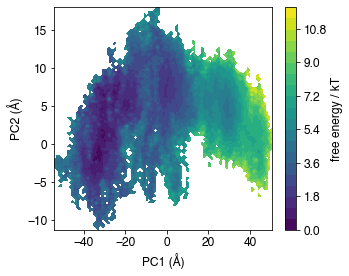

In [4]:
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'figure.figsize': [5, 4]})
mplt.plot_free_energy(xall, yall, weights=W, levels=20,cmap="viridis")
#plt.xlim(-70,60)
#plt.ylim(-15,20)
plt.xlabel("PC1 (Å)")
plt.ylabel("PC2 (Å)")
plt.tight_layout()
#plt.savefig("String_FEL.png", dpi=300)

# Definition of the functions

In [5]:
def re_point(current):
    next_pos = current.copy()
    
    path_length = []
    total_length = 0
    for i in range(len(current)-1):
        d = np.linalg.norm(current[i]-current[i+1])
        path_length.append(d)
        total_length += d
    part_length = total_length/(len(current)-1)
    #print("Total length", total_length)
    current_old_pos = 0

    for i in range(1, len(current)-1):
        summing = 0
        position = 0
        while (summing < part_length*i):
            summing += path_length[position]
            position += 1
        diff = part_length*i - sum(path_length[0:position-1])
        next_pos[i] = current[position-1]  + (current[position]-current[position-1])*(diff/path_length[position-1])
    return next_pos, total_length

In [6]:
from sklearn.neighbors import NearestNeighbors

def get_com(data, coord):
    neigh = NearestNeighbors(n_neighbors=500, radius=0.4)
    neigh.fit(data[::1])
    nbrs = neigh.kneighbors( [[coord[0],coord[1]]], return_distance=False)
    return np.average(data[::1][nbrs[0]], axis=0)

In [7]:
from sklearn.neighbors import NearestNeighbors

def get_weighted_com(data, coord, weight, n_neighbors=500):
    neigh = NearestNeighbors(n_neighbors=n_neighbors, radius=0.4)
    neigh.fit(data[::1])
    nbrs = neigh.kneighbors( [[coord[0],coord[1]]], return_distance=False)
    return np.average(data[::1][nbrs[0]], axis=0, weights=weight[nbrs[0]])

# Initial path setup（point_num=200, initial_pc1, initial_pc2）

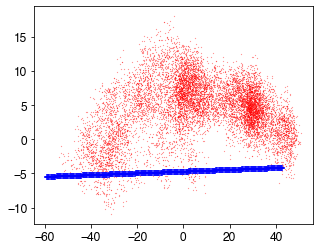

In [8]:
point_num = 200
initial_pc1 = np.linspace(-58.9, 42.8, point_num)
initial_pc2 = np.linspace(-5.5, -4.2, point_num) 

initial = np.array([[pc1,pc2] for pc1, pc2 in zip(initial_pc1, initial_pc2)], dtype = 'float64')
data_reduce = 10
plt.scatter(xall[::data_reduce], yall[::data_reduce],color='r',marker='.',s=0.1)
plt.scatter(initial[:,0], initial[:,1],color='b',marker='+')

# Performance of the cycle and plot（is_not_shrink=0, cycle=30, n_neighbors=500）

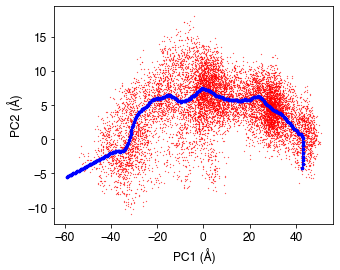

In [9]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import copy

global current
current = initial.copy()
fig = plt.figure(figsize=(5,4))
total_lengths = []
timeseries = [initial.copy()]

def init():
    data_reduce = 10
    plt.scatter(xall[::data_reduce], yall[::data_reduce],color='r',marker='.', s=0.1)
    plt.plot(current[:,0], current[:,1],color='b',marker='.', linewidth=1, markersize=5)
    plt.xlabel("PC1 (Å)")
    plt.ylabel("PC2 (Å)")
    
def update(frame):
    global current, total_lengths
    data_reduce = 10
    plt.cla()
    plt.scatter(xall[::data_reduce], yall[::data_reduce],color='r',marker='.', s=0.1)
    plt.plot(current[:,0], current[:,1],color='b',marker='.', linewidth=1, markersize=5)
    next_pos  = copy.deepcopy(current)
    #plt.annotate(f"frame: {frame}", xy=(-10,10))
    
    is_fixed_terminal = 1 # if fixed 1, not fixed 0
    for pos in range(is_fixed_terminal,len(current)-is_fixed_terminal):
        next_pos[pos] = get_weighted_com(np.array([xall, yall], dtype = 'float64').T[::data_reduce], current[pos], W[::data_reduce], n_neighbors=500)
    current, t = re_point(next_pos)
    timeseries.append(current)
    total_lengths.append(t)

cycle = 30
ani = FuncAnimation(fig, update, frames=tqdm(range(cycle+1)), init_func=init,  interval=1000)
# If you save .gif file, you need to comment out "HTML(ani.to_jshtml())" line.
#ani.save("String_animation.gif", writer = 'pillow',dpi=300)
HTML(ani.to_jshtml())

# Plot the convergence of the string length

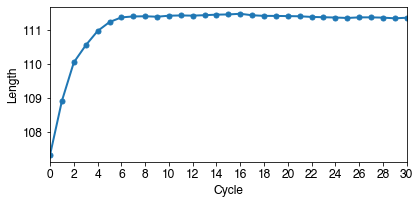

In [10]:
fig = plt.figure(figsize=(6,3))
plt.plot(total_lengths, linewidth=2, marker=".", markersize=10)
plt.xlabel("Cycle")
plt.ylabel("Length")
plt.xticks([i for i in range(0,cycle+1,1) if i%2 ==0 ],[i for i in range(0,cycle+1,1) if i%2 ==0 ])

plt.xlim(0,cycle)
plt.tight_layout()
plt.savefig("String_converge.png", dpi=300)

# Plot transition of the string（skip=6）

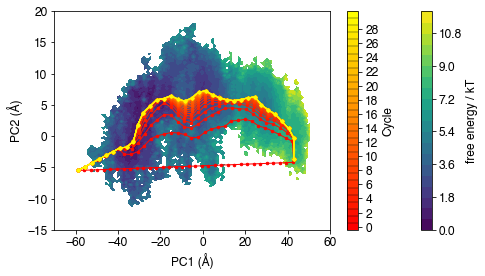

In [11]:
import matplotlib.patheffects as PathEffects
from matplotlib.colors import ListedColormap, BoundaryNorm, rgb2hex
fig = plt.figure(figsize=(7,4))
ax = plt.subplot()
mplt.plot_free_energy(xall, yall, weights=W, levels=20,cmap="viridis", ax=ax)
plt.xlim(-70,60)
plt.ylim(-15,20)
plt.xlabel("PC1 (Å)")
plt.ylabel("PC2 (Å)")
cmap = plt.get_cmap("autumn")

skip=6
skip_cycle=1
for i in range(0, len(timeseries)):
    if i%skip_cycle ==0:
        ax.plot(timeseries[i][::skip,0], timeseries[i][::skip,1],color=cmap(i/len(timeseries)),marker='.', linewidth=1, markersize=5)

d_cmap = cm.get_cmap("autumn",cycle+2)
dis_cmap = ListedColormap([rgb2hex(d_cmap(i)[:3]) for i in range(d_cmap.N)])
bounds = [i/(cycle+1) for i in range(0,cycle+2,1)]
norm = BoundaryNorm(bounds,dis_cmap.N)
cbar = fig.colorbar(cm.ScalarMappable(norm=None, cmap=dis_cmap), ax=plt.gca(), boundaries= bounds, ticks=[((i/(cycle+1))+0.05)-0.1 for i in range(0,cycle+2,2)], drawedges=True)

cbar.ax.set_ylim(0,1)
cbar.ax.set_yticklabels([i for i in range(0,cycle,2)])
cbar.ax.set_ylabel("Cycle")

plt.tight_layout()
plt.savefig("String_transition.png", dpi=300)

# Show MFEP（skip=6）

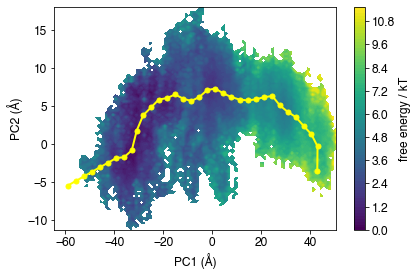

In [12]:
fig = plt.figure(figsize=(6,4))
ax = plt.subplot()
mplt.plot_free_energy(xall, yall, weights=W, levels=100,cmap="viridis",ax=ax)
#mplt.plot_free_energy(xall, yall, weights=W, levels=100,cmap="jet_r", ax=ax)
#plt.xlim(-70,60)
#plt.ylim(-15,20)
plt.xlabel("PC1 (Å)")
plt.ylabel("PC2 (Å)")
cmap = plt.get_cmap("autumn")

skip=6
ax.plot(timeseries[-1][::skip,0], timeseries[-1][::skip,1],color=cmap(1.0),marker='.', linewidth=2, markersize=10)
#ax.plot(timeseries[-1][::skip,0], timeseries[-1][::skip,1],color="blue",marker='.', linewidth=2, markersize=10)
plt.tight_layout()
plt.savefig("String_MFEP.png", dpi=300)

# Calculate free energy along the MFEP（mfep_bin = 100）

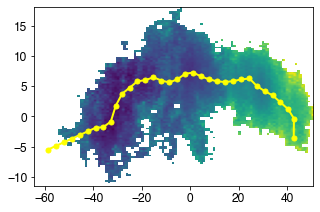

In [13]:
mfep_bin = 100
H = np.histogram2d(xall,yall, bins=mfep_bin, weights=W)
datanumber = np.sum(H[0])
with np.errstate(divide='ignore'):
    logedH = -np.log(H[0].T/datanumber)
minimalenagy = np.min(logedH)
im = plt.imshow(logedH - minimalenagy, origin='lower', extent=[H[1][0], H[1][-1], H[2][0], H[2][-1]], cmap="viridis",aspect=2.5)
plt.plot(current[::skip,0], current[::skip,1],color=plt.get_cmap("autumn")(1.0),marker='.', linewidth=2, markersize=10)


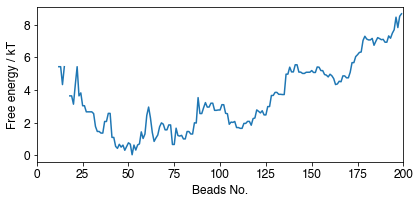

In [14]:
current_energy = [0.0] * len(current)
for i, c in enumerate(current):
    x_index = 0
    y_index = 0
    for index, x_edge in enumerate(H[1]):
        if c[0] < x_edge:
            x_index = index-1
            break
    for index, y_edge in enumerate(H[2]):
        if c[1] < y_edge:
            y_index = index-1
            break
    current_energy[i] = (logedH[y_index, x_index] - minimalenagy)#*0.593 # for kcal/mol
fig = plt.figure(figsize=(6,3))
plt.plot(current_energy)
plt.xlim(0, len(current))
plt.xlabel("Beads No.")
plt.ylabel("Free energy / kT")
plt.tight_layout()
plt.savefig("String_along_MFEP.png", dpi=300)

The end of the notebook